# Models III: Multiple Regression with `statsmodels`

## Learning Goals

In the previous notebook we learned how to use `statsmodels` to perform a **univariate regression**, i.e. *1 predictor variable*. In this notebook we're going to extend this to **multiple regression** that includes *2+ predictor variables*. Specifically, we're going to focus on *continuous variables* as we've been doing so far. In future notebooks, we'll discuss how we can using the GLM to model *categorical variables*.

- Estimating a multiple regression using OLS with `statsmodels`
- Interpreting parameter estimates 
- Interactions between predictor variables
- Evaluating multi-collinearity - another modeling assumption
- Revisiting centering predictor variables
- Parameter inference via model comparison
- Parameter inference via uncertainty estimation

## Slides for reference

[Modeling Data I (slides)](https://stat-intuitions.com/lectures/wk5/1.html)  
[Modeling Data II (slides)](https://stat-intuitions.com/lectures/wk5/2.html)  
[Modeling Data II 1/2 (slides)](https://stat-intuitions.com/lectures/wk5/3.html)  

## Data

Let's learn how to fit a multiple regression model using `statsmodels`. 

We'll be using a **different** dataset of advertisement spending on different types of media and the resulting sales generated. Here are the columns:

| Variable   | Description                     |
|------------|---------------------------------|
| tv     | TV ad spending in $1000 of  dollars            |
| radio     | Radio ad spending in $1000 of  dollars            |
| newspaper     | Newspaper ad spending in $1000 of  dollars            |
| sales     | Sales generated in $1000 of  dollars            |

In [66]:
import numpy as np
import polars as pl
from polars import col
import seaborn as sns
import matplotlib.pyplot as plt
df = pl.read_csv('./data/advertising.csv')
df

tv,radio,newspaper,sales
f64,f64,f64,f64
230.1,37.8,69.2,22.1
44.5,39.3,45.1,10.4
17.2,45.9,69.3,9.3
151.5,41.3,58.5,18.5
180.8,10.8,58.4,12.9
…,…,…,…
38.2,3.7,13.8,7.6
94.2,4.9,8.1,9.7
177.0,9.3,6.4,12.8


## Our Statistical Question

The primary question we're interested in answering is: 

**Can we predict sales better when we consider radio ads *in addition* to TV ads?**

Or stated differently:

**"Controlling" for TV ads, do radio ads explain any additional variance in sales?**

We can formalize this as comparison between 2 models:

$$
\begin{align*}
\text{Simple Regression} \\
sales_i &= \beta_0 + \beta_1 tv_i \\
\text{v}s \\
\text{Multiple Regression} \\
sales_i &= \beta_0 + \beta_1 tv_i + \beta_2 radio_i
\end{align*}
$$

Remember multiple regression is yet another "flavor" of the GLM where we have more than one predictors variable $X$ being used to model an outcome variable $y$.

<div align="center">
<img src="./figs/multr.png" width="60%" alt="Figure 1">
</div>

## Visual Exploration

Before you build any model you should **always plot your data first**. This will give you better idea of what your data looks like any any modeling choices you might make.  

Let's use `seaborn` to plot our data:

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt # for customization

Let's look at a scatterplot between each of $X$ variables and our $y$ variable.  
We'll also take a look at the relationship between the two $X$ variables as well:

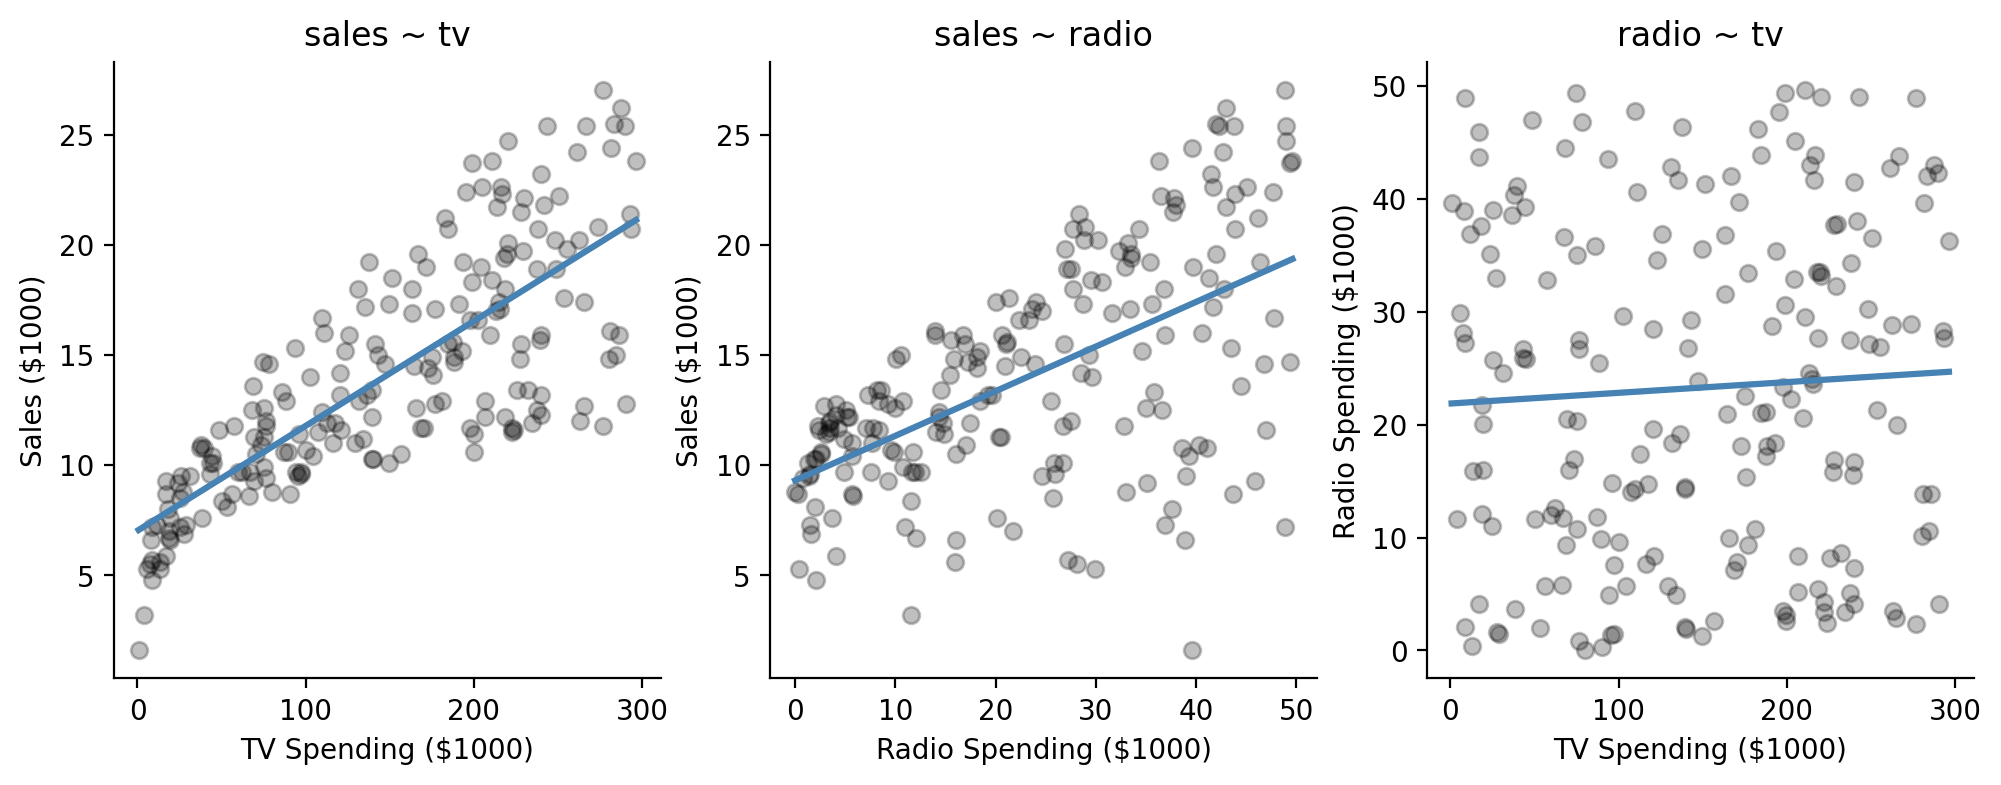

In [68]:
f, axs = plt.subplots(1,3, figsize=(12,4))

ax = sns.regplot(
    data=df,
    x='tv',
    y='sales',
    color='black',
    scatter_kws={'alpha': .25},
    ci=False,
    line_kws={'color': 'steelblue'},
    ax=axs[0]
)
ax.set(xlabel='TV Spending ($1000)', ylabel='Sales ($1000)', title="sales ~ tv");

ax = sns.regplot(
    data=df,
    x='radio',
    y='sales',
    color='black',
    scatter_kws={'alpha': .25},
    ci=False,
    line_kws={'color': 'steelblue'},
    ax=axs[1]
)
ax.set(xlabel='Radio Spending ($1000)', ylabel='Sales ($1000)', title="sales ~ radio");

ax = sns.regplot(
    data=df,
    x='tv',
    y='radio',
    color='black',
    scatter_kws={'alpha': .25},
    ci=False,
    line_kws={'color': 'steelblue'},
    ax=axs[2]
)
ax.set(xlabel='TV Spending ($1000)', ylabel='Radio Spending ($1000)', title="radio ~ tv");
sns.despine();

We can actually make this a lot easier and explore **all** the pairwise relationships in our data using `seaborn`'s [`pairplot` function](https://seaborn.pydata.org/generated/seaborn.pairplot.html).  

This also gives us the *distribution* of each variable. We an see that our $y$, $sales$ looks pretty normal, whereas $newspaper$ looks a bit skewed, and $tv$ and $radio$ look pretty uniform

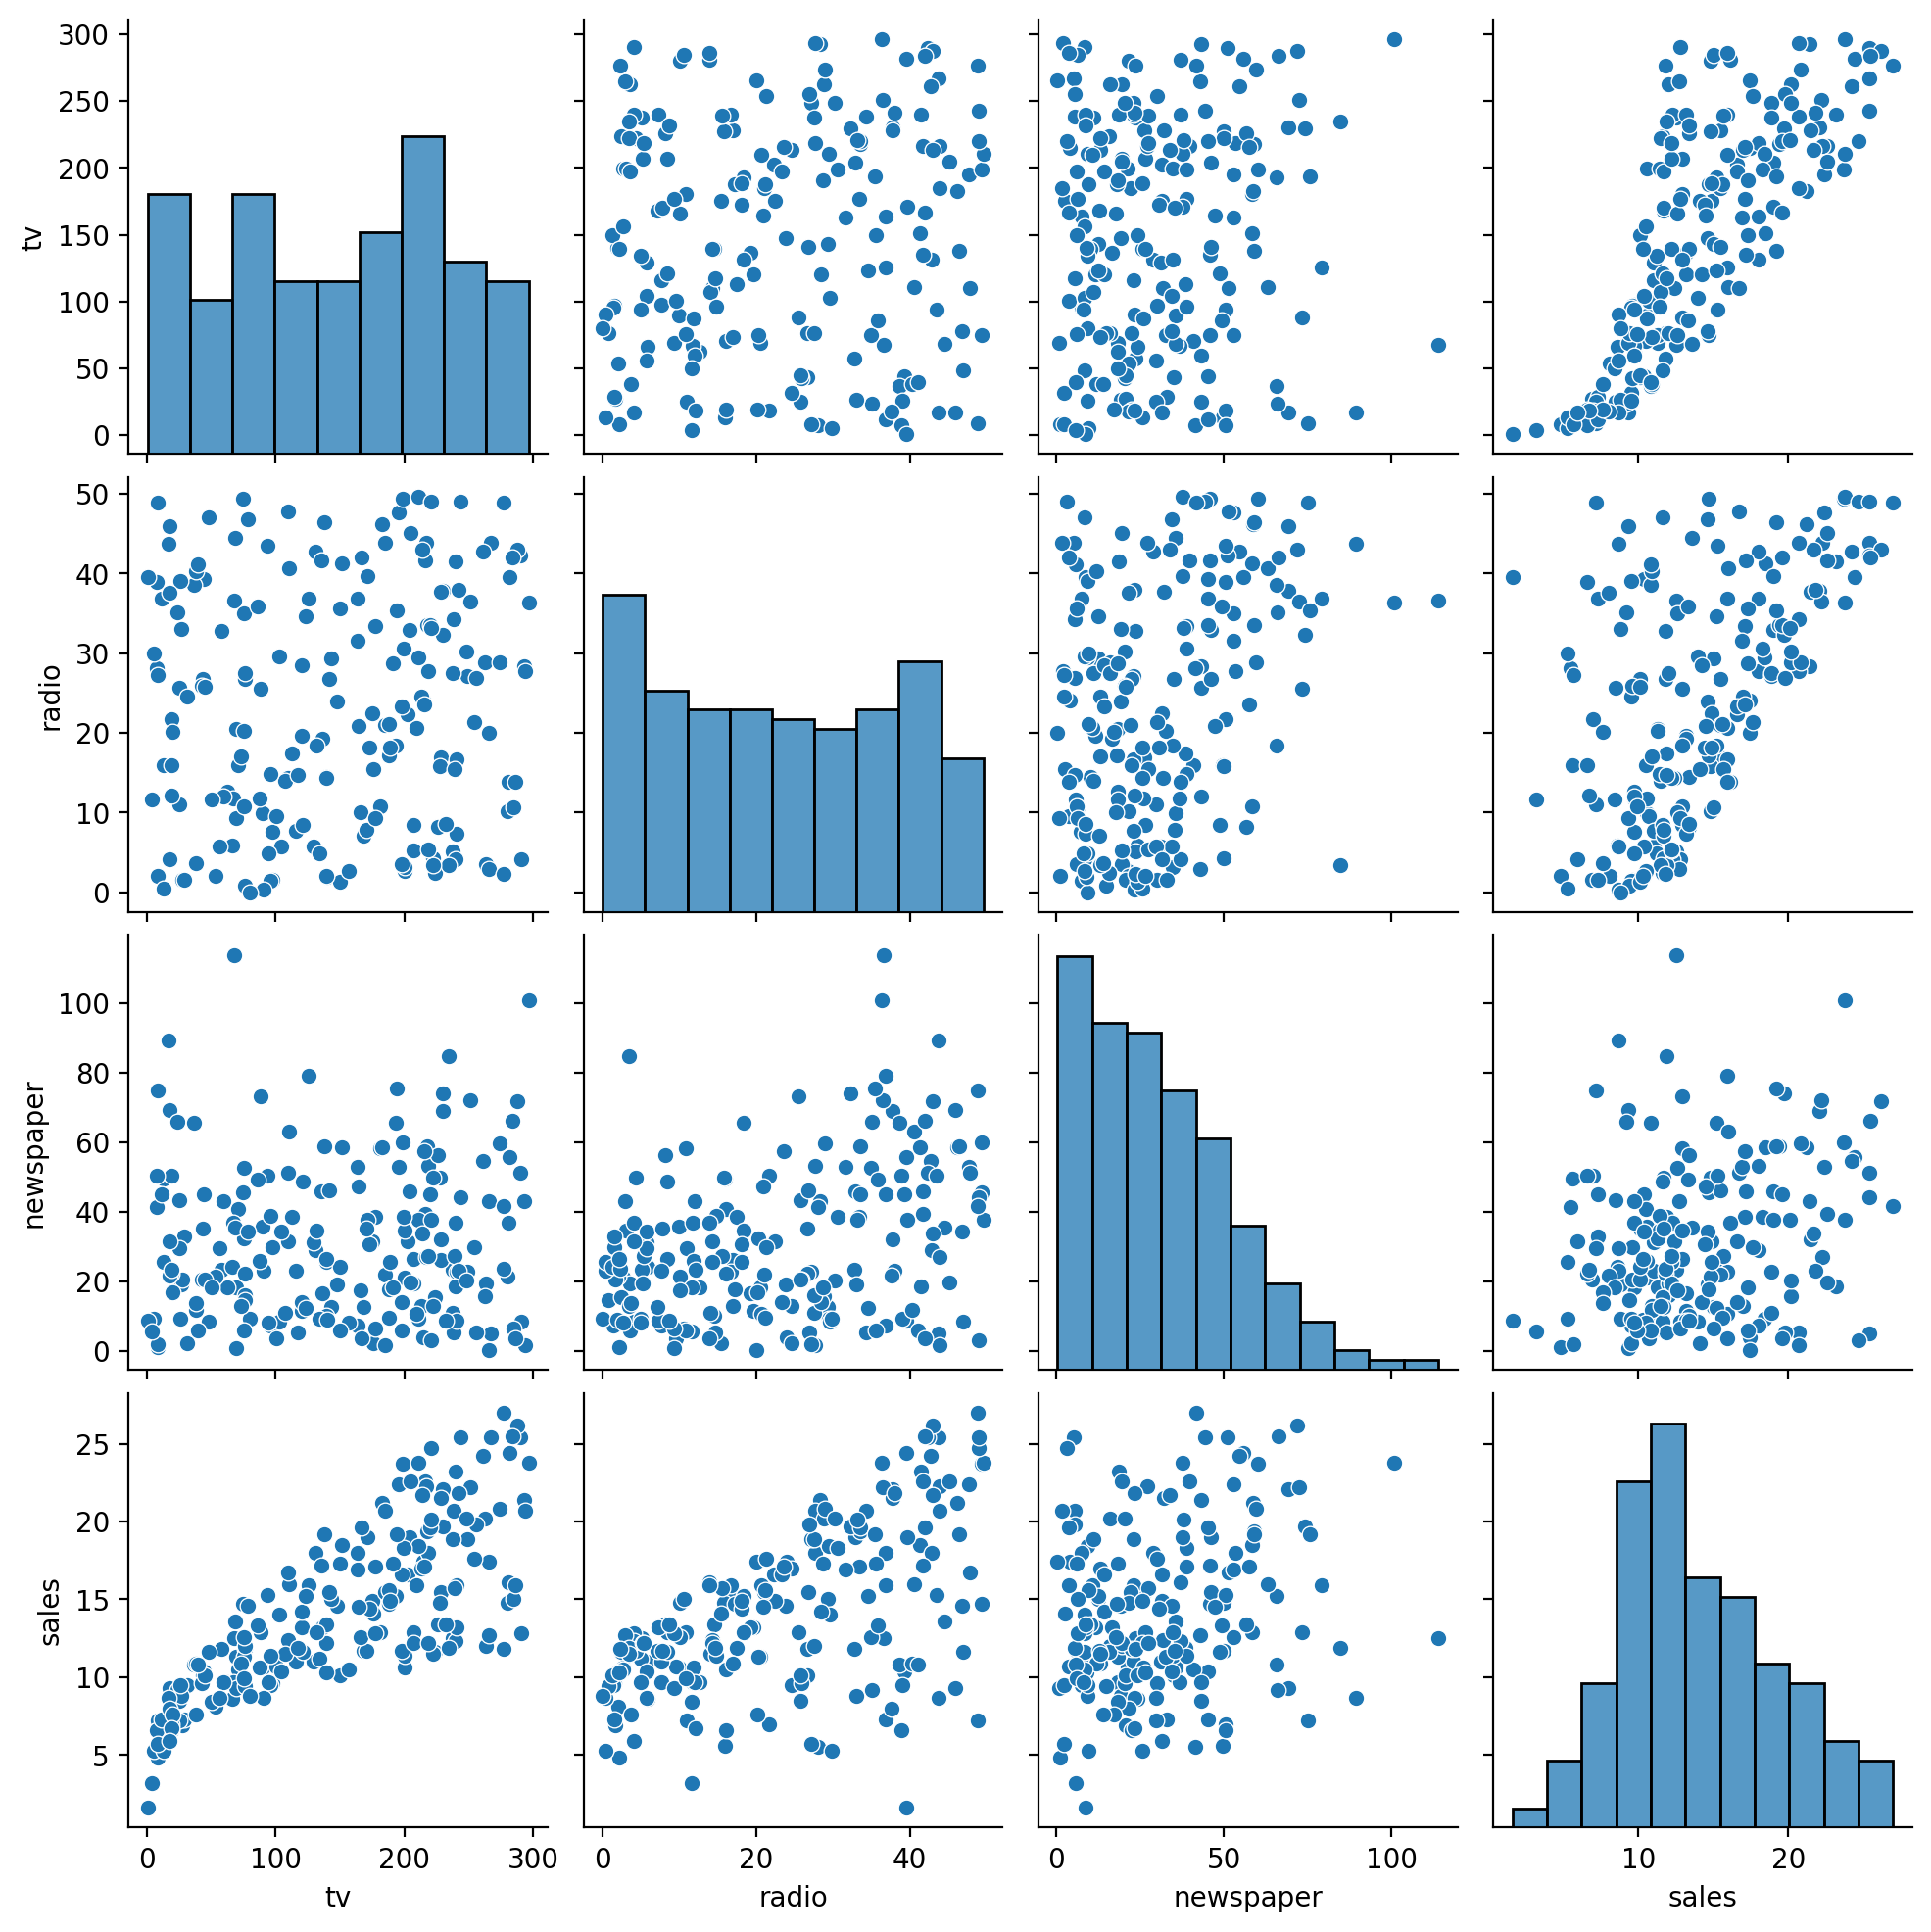

In [69]:
# We need to use .to_pandas() with pairplot
sns.pairplot(df.to_pandas())

Creating a heatmap of the **correlation matrix** between all variables is another great way to visualize pairwise relationships. First we'll use `.corr()` in polars to calculate the pairwise correlation between all columns:

In [70]:
# Ask polars to correlate all pairs of columns except the first
corr_mat = df.corr()

corr_mat

tv,radio,newspaper,sales
f64,f64,f64,f64
1.0,0.054809,0.056648,0.782224
0.054809,1.0,0.354104,0.576223
0.056648,0.354104,1.0,0.228299
0.782224,0.576223,0.228299,1.0


Then we can use seaborn's [heatmap](https://seaborn.pydata.org/generated/seaborn.heatmap.html) to visualize this with options to pick a decent color palette and annotate the matrix with the r-values.

This tells us that:

- $r_{tv, sales} = 0.78$
- $r_{radio, sales} = 0.58$
- $r_{radio, tv} = 0.05$.

So both predictors ($tv$ and $radio$) see to have some decently strong **independent** correlations with $sales$. 

And our two predictors don't appear to be very correlated with each other (we will revisit this...) 

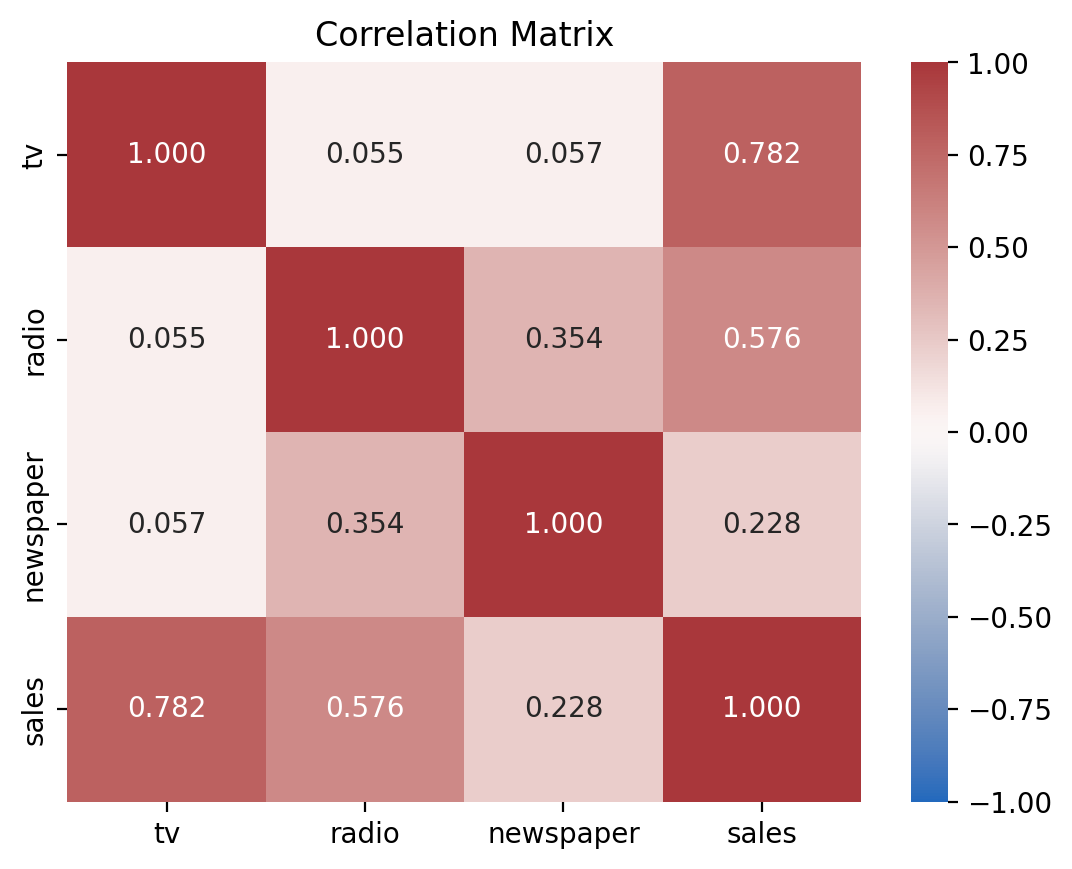

In [78]:
ax = sns.heatmap(
    corr_mat,
    cmap='vlag', 
    vmin=-1, 
    vmax=1, 
    xticklabels=corr_mat.columns,
    yticklabels=corr_mat.columns,
    annot=True, fmt=".3f")
ax.set_title("Correlation Matrix");

Another way we can look at these data is my mapping one of our continuous predictors to `hue` and `size` in a scatterplot. Since we're interested in whether the *addition of radio* as a predictor changes our ability to predict sales, let's put $tv$ on the x-axis, $sales$ on the y-axis, and $radio$ on the hue.

Visualized this way it looks like the relationship between $TV$ and $sales$ might get *steeper* as $radio$ increases.

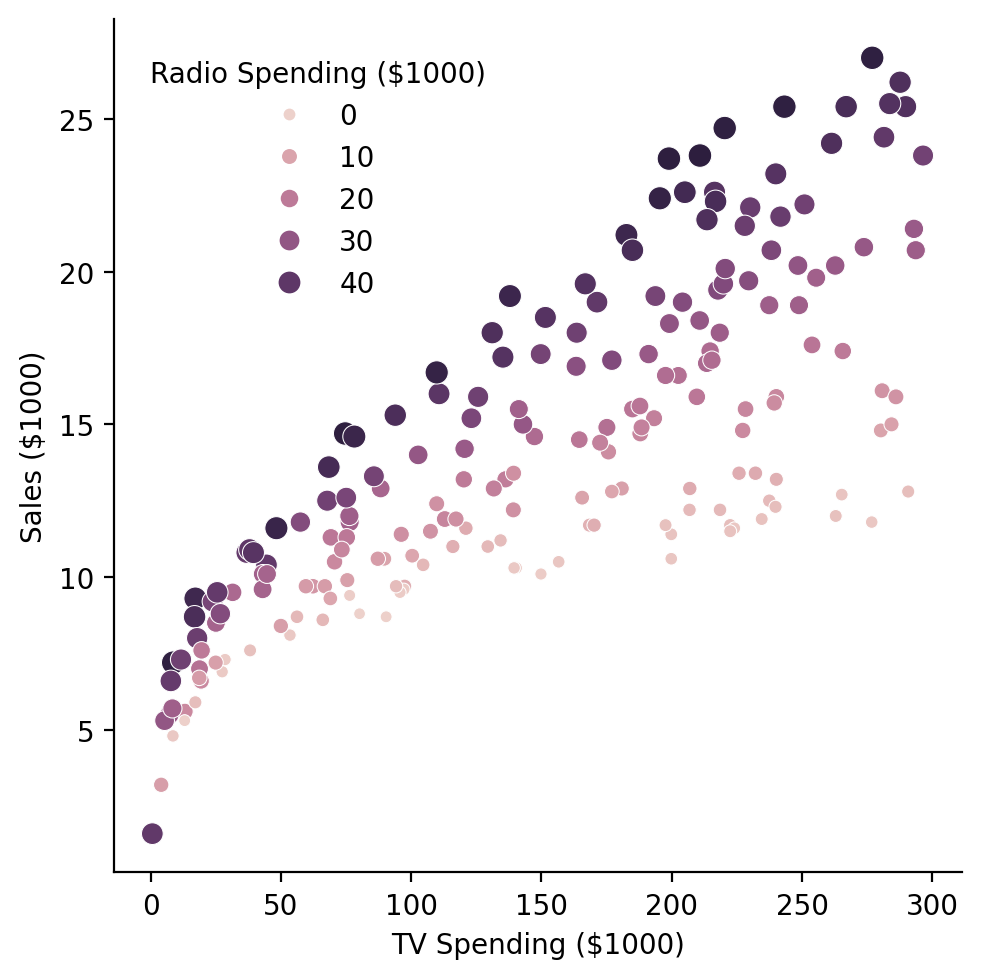

In [54]:
grid = sns.relplot(
    data=df,
    kind='scatter',
    x='tv',
    y='sales',
    hue='radio',
    size='radio',

)
grid.set(xlabel='TV Spending ($1000)', ylabel='Sales ($1000)');
grid.legend.set_title('Radio Spending ($1000)');
grid.legend.set_bbox_to_anchor((.45, .8));

## Estimation, Comparison, & Evaluation

Let's go ahead and formulate our hypothesis a comparison between the two models using `ols` from statsmodels and was whether adding $radio$ as a predictor is **worth it**

Here's what we'll do:

1. Define each model using the `ols` function and *formula syntax*
2. Call `.fit()` on each model and save each model's results to a new variable
3. Use `anova_lm()` to test our **worth it** question

$$
\begin{align*}
\text{Compact Model} \\
sales_i &= \beta_0 + \beta_1 tv_i \\
\text{v}s \\
\text{Augmented Model} \\
sales_i &= \beta_0 + \beta_1 tv_i + \beta_2 radio_i
\end{align*}
$$


In [80]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


compact_model = ols('sales ~ tv', data=df)
augmented_model = ols('sales ~ tv + radio', data=df)

compact_results = compact_model.fit()
augmented_results = augmented_model.fit()

anova_lm(compact_results, augmented_results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,198.0,2102.530583,0.0,NaN,NaN,NaN
1,197.0,556.913980,1.0,1545.616603,546.738781,9.776972e-59


It's worth it!

Now let's evaluate how the model is actually performing. Like the previous notebook, we'll add some columns to our DataFrame to store the predictions and the residuals for plotting.

In [ ]:
df = df.with_columns(
    residuals = augmented_results.resid.to_numpy(),
    predicted_sales = augmented_results.fittedvalues.to_numpy(),
)

Let's look at the shape of the histogram for normality...not too bad but skewed

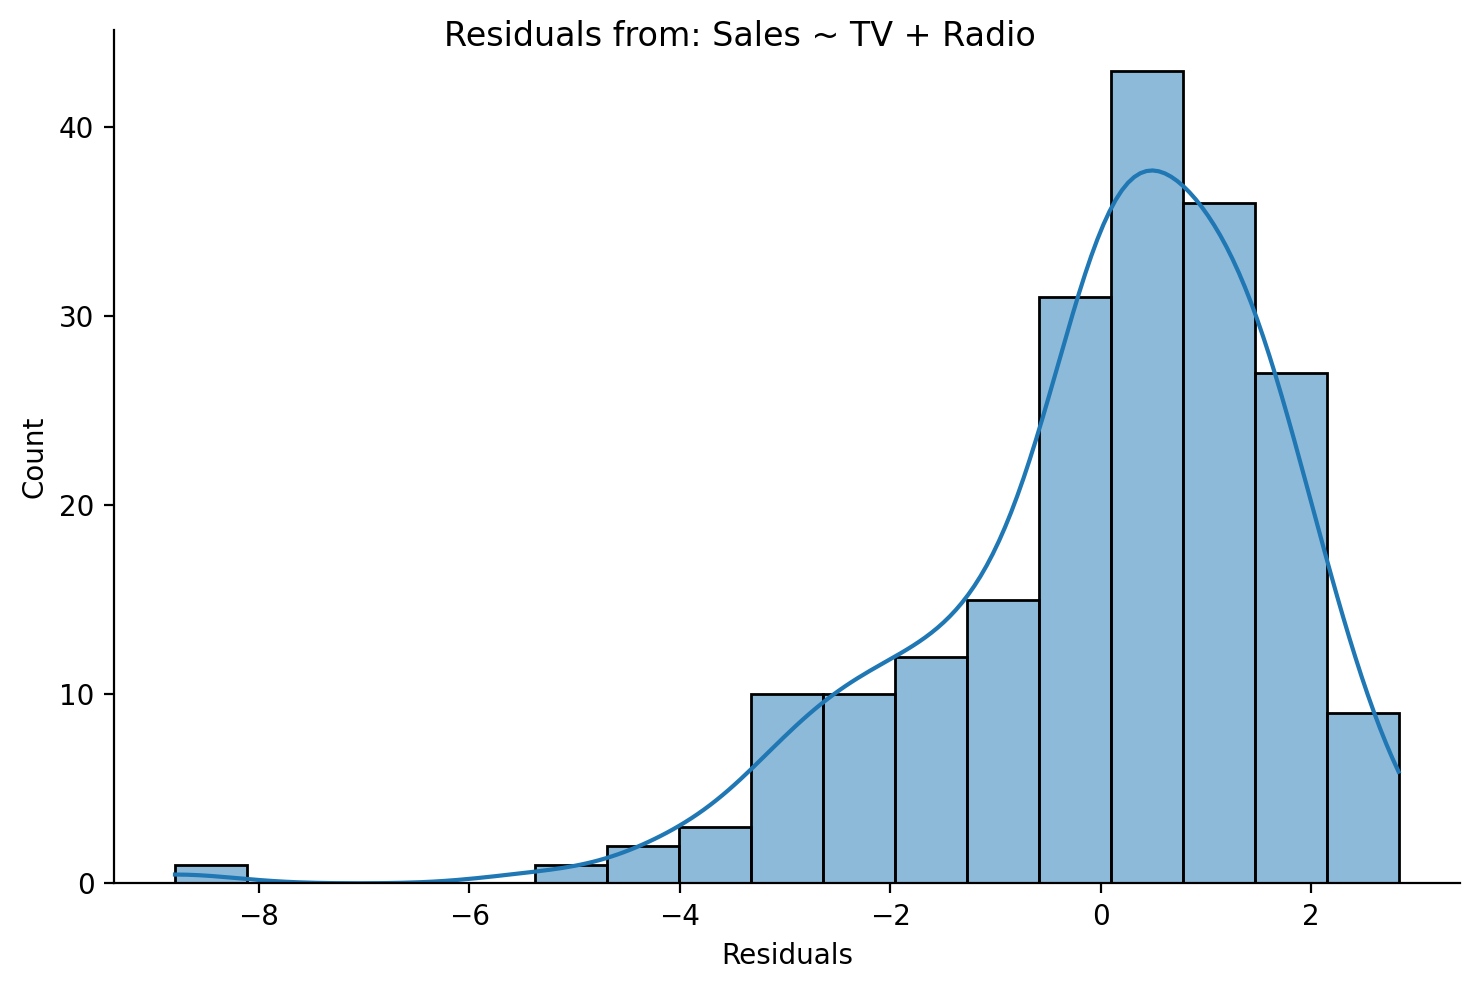

In [88]:
grid = sns.displot(data=df,x='residuals',height=5,aspect=1.5, kde=True)
grid.set_axis_labels('Residuals','Count');
grid.figure.suptitle('Residuals from: Sales ~ TV + Radio');

And the qqplot shows the same:

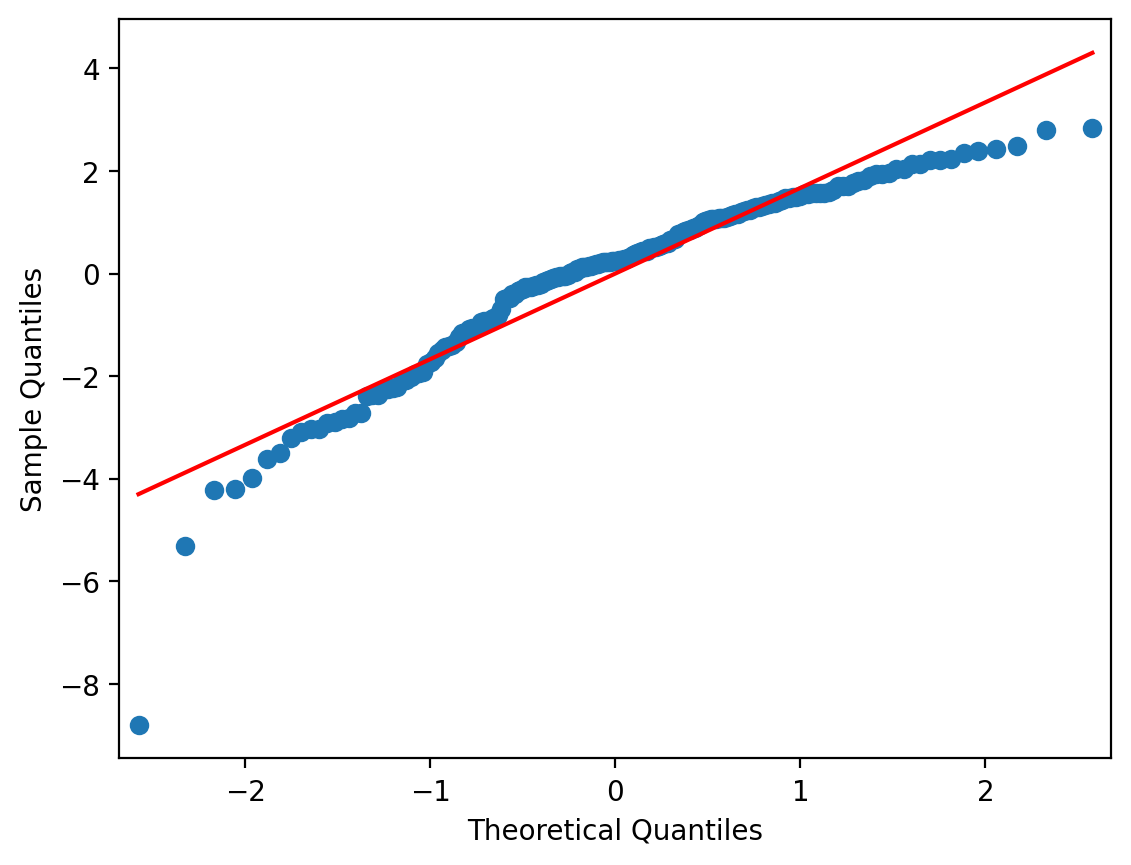

In [89]:
from statsmodels.graphics.gofplots import qqplot

qqplot(df['residuals'], line = 's');

Finally plotting $sales$ against $\hat{sales}$ gives us sense of overall fit to the data. We can also fetch the $R^2$ value that `statsmodels` calculates for us to put it in the title:

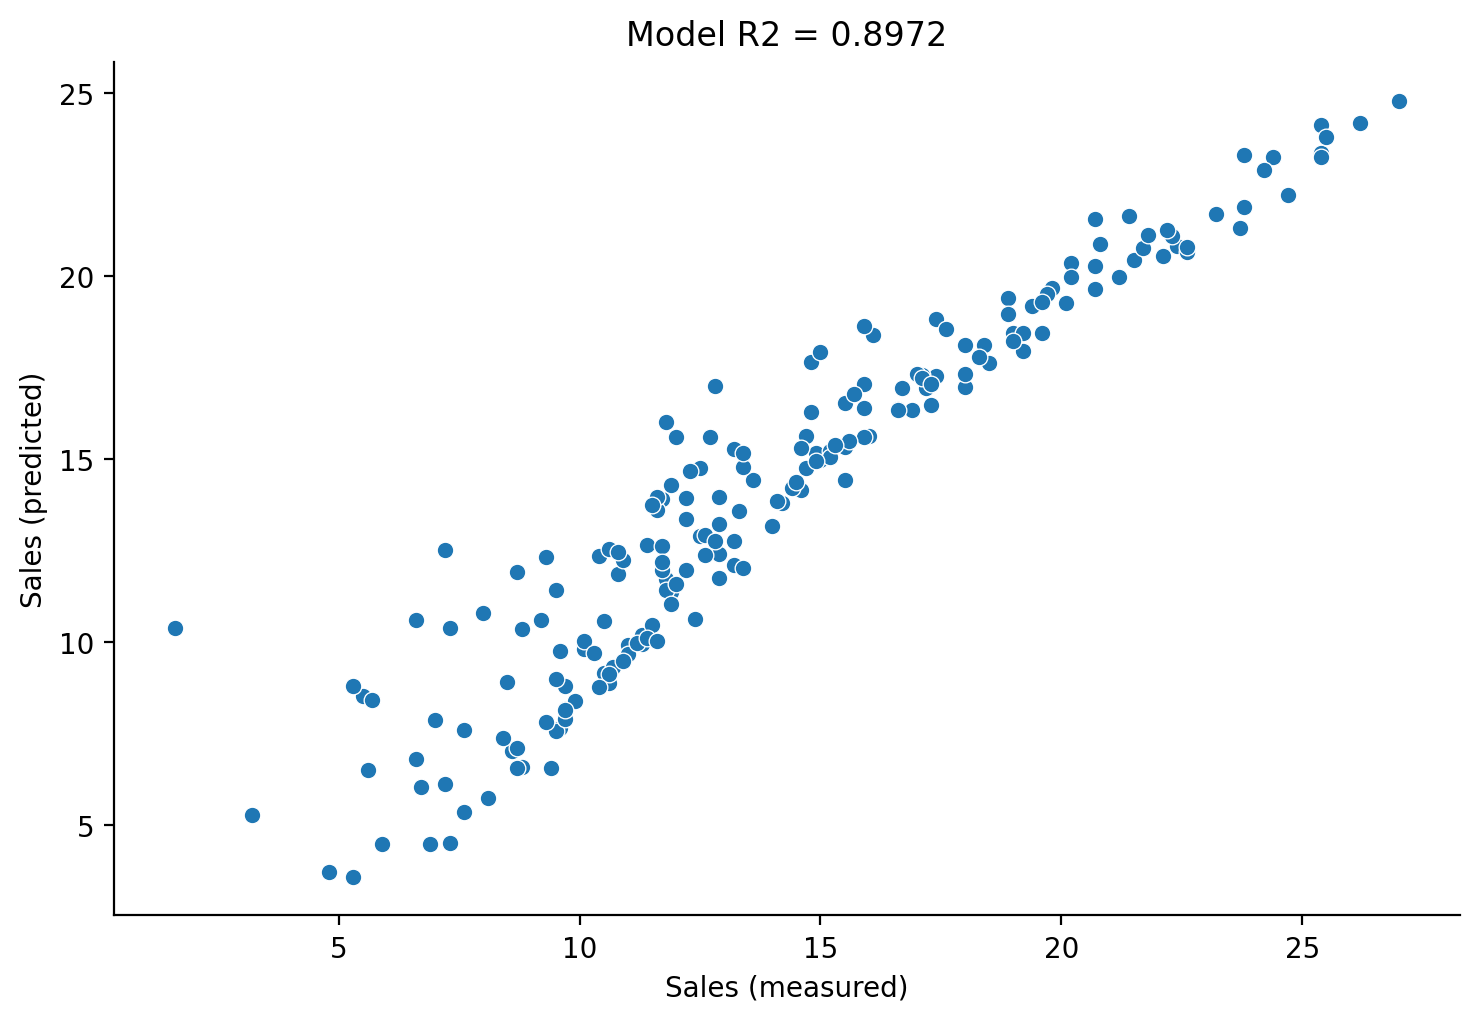

In [95]:
grid = sns.relplot(
    data=df,
    x="sales",
    y="predicted_sales",
    kind='scatter',
    height=5,
    aspect=1.5,
)

# Labels and legend
grid.set_axis_labels('Sales (measured)', 'Sales (predicted)');
grid.set(title=f"Model R2 = {augmented_results.rsquared:.4f}");


## Parameter Interpretation

Let's finally used `.summary()` to get a sense of the parameter estimates and their uncertainty:

In [94]:
print(augmented_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     859.6
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           4.83e-98
Time:                        14:05:16   Log-Likelihood:                -386.20
No. Observations:                 200   AIC:                             778.4
Df Residuals:                     197   BIC:                             788.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9211      0.294      9.919      0.0

Here's how the output relates to out original original model equation:

$$
\begin{align*}
sales_i &= \beta_0 + \beta_1 tv_i + \beta_2 radio_i \\
sales_i &= \beta_0 + .046*tv_i + .188*radio_i
\end{align*}
$$

And he's how we'd report this:

*For a given amount of TV advertising, an additional $1000 spending on radio advertising is associated with an increase in sales by 188 units.*

**Note:** The $1000 spending and 188 units are due the the *measurement scale* of our variables - they're reported in "units of $1000 of spending" so we shift everything over by 3 decimal places (x1000) to make interpretation easier.

### Marginal predictions

To get a better idea of the relationship between $sales$ and any of our predictors, we can generate **marginal predictions**. These are predicted values $\hat{sales}$ when we hold one or more of the predictors at a constant value.

We can use the `.predict()` method on a model's results to generate predictions given some input of the original predictor variables. These should be specified as a dictionary, where the keys are the names of the predictors and the values are the values to hold them at.

Let's see an example of making this prediction:

$$
sales_i = 2.92 + 100*tv_i + 0*radio_i
$$


In [120]:
augmented_results.predict(dict(
    tv=100,
    radio=0
))

0    7.496581
dtype: float64

This tells us that $\hat{sales} = 7.49$ or

$$
7.49 = \beta_0 + 100*tv_i + 0*radio_i
$$

We can also generate *multiple*p predictions at once by giving `.predict` an array or list of predictor values.  
We'll generate predictions for $sales$ using our *observed* values for $tv$, but hold $radio = 0$

In [121]:
# Save to variable just to make coding easier
tv = df['tv'].to_numpy()

# We use all values in the TV column
# And just a bunch of 0s for radio
y_radio_0 = augmented_results.predict(dict(
    tv=tv, 
    radio=np.repeat(0, len(tv))
    ))

This gives us 200 $\hat{sales}$ predictions using our estimated coefficients but specifically when we set $radio =0$.

In [122]:
y_radio_0

0      13.449283
1       4.957189
2       3.708083
3       9.852954
4      11.193570
         ...    
195     4.668934
196     7.231203
197    11.019702
198    15.897165
199    13.540792
Length: 200, dtype: float64

Let's repeat this process and update one of our first scatterplots:

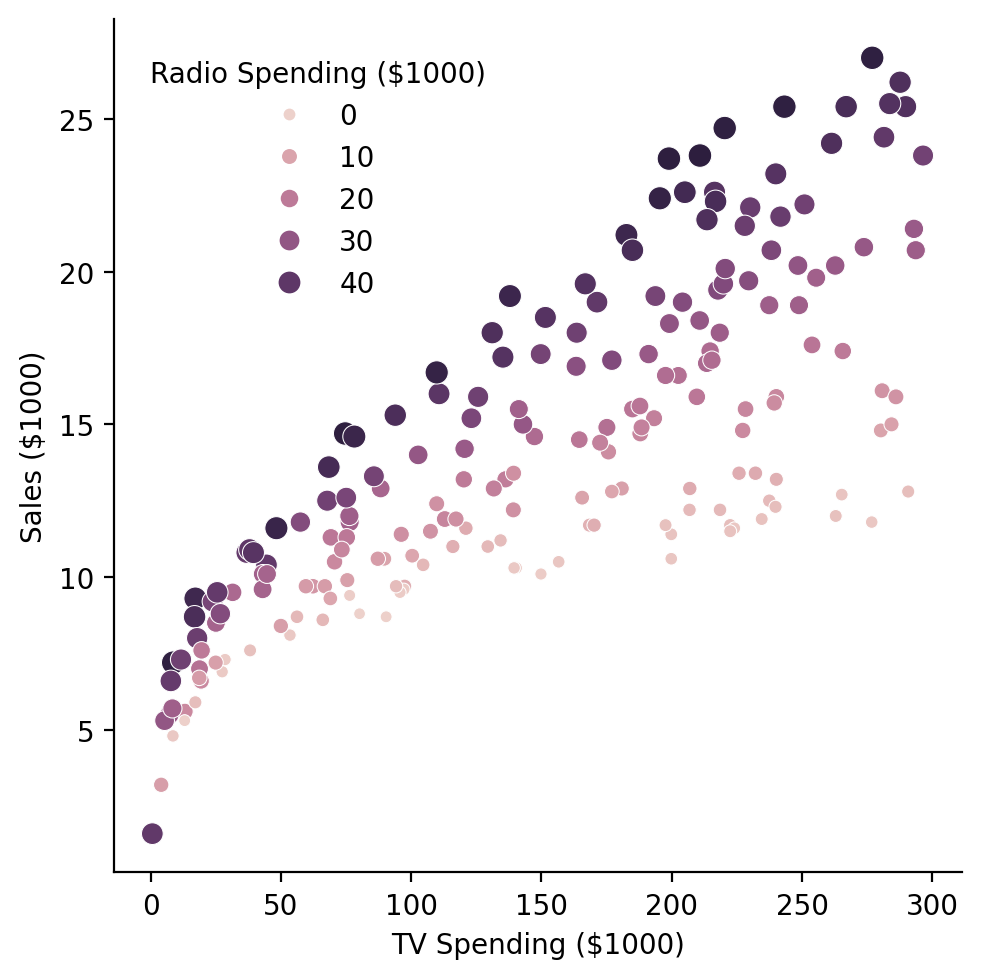

In [123]:
grid = sns.relplot(
    data=df,
    kind='scatter',
    x='tv',
    y='sales',
    hue='radio',
    size='radio',

)
grid.set(xlabel='TV Spending ($1000)', ylabel='Sales ($1000)');
grid.legend.set_title('Radio Spending ($1000)');
grid.legend.set_bbox_to_anchor((.45, .8));

To get a better sense of the changing relationship between $tv$ and $sales$ across different values of $radio$, we create 3 sets of predictions and plot them as lines:

$$
\begin{align*}
\hat{sales} &= \beta_0 + \beta_1*tv_i + 0*radio_i \\
\hat{sales} &= \beta_0 + \beta_1*tv_i + 20*radio_i \\
\hat{sales} &= \beta_0 + \beta_1*tv_i + 40*radio_i \\
\end{align*}
$$

In [ ]:
# We use all values in the TV column a bunch of 20s for radio
y_radio_20 = augmented_results.predict(dict(
    tv=tv, 
    radio=np.repeat(20, len(tv))
    ))

# We use all values in the TV column a bunch of 40s for radio
y_radio_40 = augmented_results.predict(dict(
    tv=tv, 
    radio=np.repeat(40, len(tv))
    ))

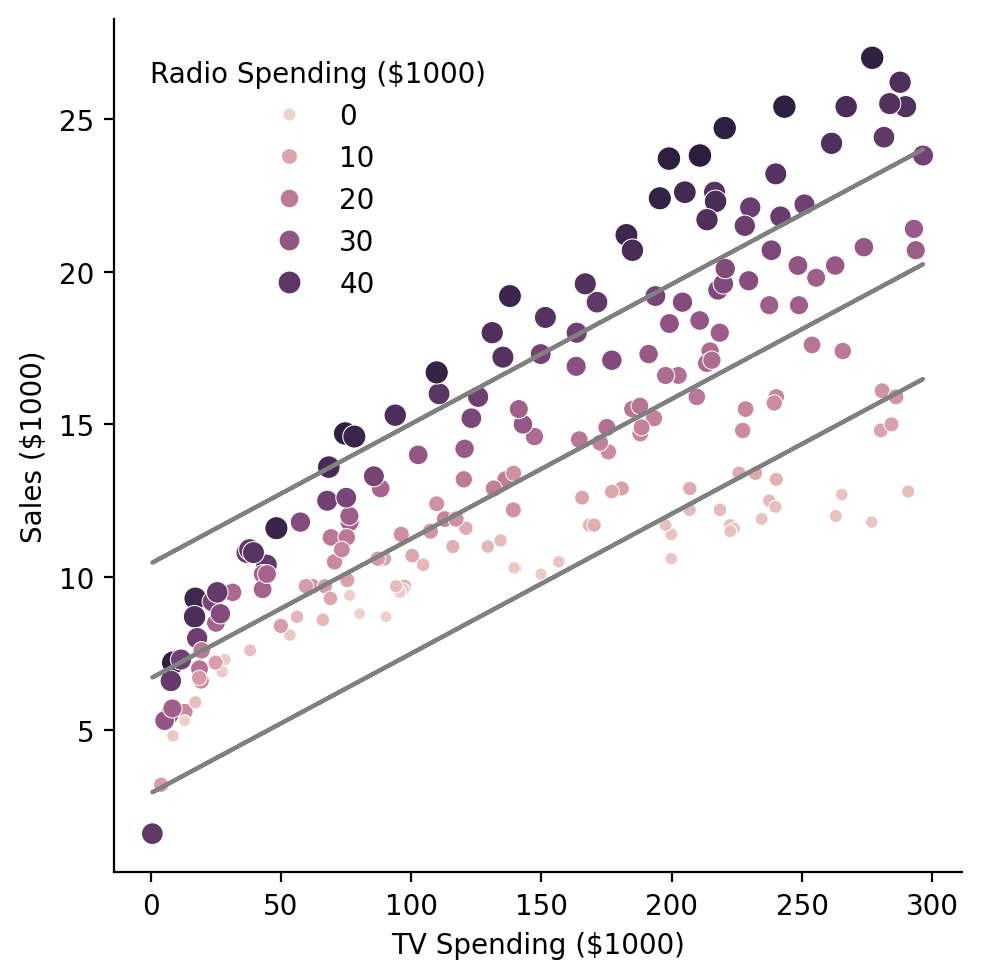

In [127]:
grid = sns.relplot(
    data=df,
    kind='scatter',
    x='tv',
    y='sales',
    hue='radio',
    size='radio',

)
grid.set(xlabel='TV Spending ($1000)', ylabel='Sales ($1000)');
grid.legend.set_title('Radio Spending ($1000)');
grid.legend.set_bbox_to_anchor((.45, .8));

# Add them to the plot
grid.ax.plot(tv, y_radio_0, color='gray');
grid.ax.plot(tv, y_radio_20, color='gray');
grid.ax.plot(tv, y_radio_40, color='gray');

### Marginal predictions are what the estimates *mean*

Remember in the last notebook, we mentioned that in GLM, we interpret each parameter estimate **assuming other parameter estimates = 0**?

To prove this to you let's take a look at our estimated slope for TV $\hat{\beta}_1$ 

In [150]:
augmented_results.params

Intercept    2.921100
tv           0.045755
radio        0.187994
dtype: float64

Ignoring the dollar $ scale of our data for a moment, this tell us that:  

When $radio$ spending = $0$, for each *unit-change* in $tv$ spending we expect a *unit-change* of $0.457$ in $sales$

Still confused? **Let's use a model to build our intuitions**  

That statement is about the slope of $tv$ when predicting $sales$ right?  

Well we recently learned how *estimate* the slope of a line between two variables...  


We can use `ols` to estimate a univariate regression between `predicted_sales ~ tv`!

Specifically we'll use the `y_radio_0` variable we created earlier which is the predicted sales when we set `radio = 0`.

Let's start by creating an new DataFrame with our predictions and original TV values:

In [151]:
df_predicted = pl.DataFrame({
    'tv': df['tv'].to_numpy(),            # original TV column
    'sales_predicted': y_radio_0          # From calling .predict() with radio = %
})
df_predicted.head()

tv,sales_predicted
f64,f64
230.1,13.449283
44.5,4.957189
17.2,3.708083
151.5,9.852954
180.8,11.19357


Then lets estimate this model and check out the slope for TV:

In [152]:
marginal_model = ols('sales_predicted ~ tv', data=df_predicted.to_pandas())
marginal_results = marginal_model.fit()
marginal_results.params

Intercept    2.921100
tv           0.045755
dtype: float64

See how it **hasn't changed**? That's because the slope for each parameter is interpreted *fixing the other parameters to 0*! 

Marginal predictions/plots **are** what the slope for each parameter is capturing!  
how much $y$ changes with one unit change of $x$ when all other $X$ are held constant (at 0 by default)


Let's see the same thing for the $radio$ variable:

In [154]:
radio = df['radio'].to_numpy()

df_predicted = pl.DataFrame({
    'radio': radio,
    'sales_predicted': augmented_results.predict(dict(
        tv=np.repeat(0, len(radio)), radio=radio))
})

marginal_model = ols('sales_predicted ~ radio', data=df_predicted.to_pandas())
marginal_results = marginal_model.fit()
marginal_results.params

Intercept    2.921100
radio        0.187994
dtype: float64

### Key takeaways

- "Marginal" or "adjusted" predictions are $\hat{y}$ where we "fix" all parameters except one to a specific value and then ask our model to make predictions
- In our example above, we fixed $radio = 0$ and generated predictions using only the values of $tv$ or visa-versa
- These predictions *are* what our **parameter estimates** are telling us: how much the dependent variable changes with one unit change in a specific independent variable - when all other independent variables are held constant (at 0 by default)

## Plotting Challenge

Create another marginal predition plot like the one above, but flip the predictors around and add in some marginal predictions for when TV spending is 0, 150, and 300

- Y-axis: Sales (same)
- X-axis: Radio spending
- Hue: TV spending

In [ ]:
# Your code here

In [ ]:
# Solution
grid = sns.relplot(
    data=df,
    kind='scatter',
    x='radio',
    y='sales',
    hue='tv',
    size='tv',

)
grid.set(xlabel='Radio Spending ($1000)', ylabel='Sales ($1000)');
grid.legend.set_title('TV Spending ($1000)');
grid.legend.set_bbox_to_anchor((.45, .8));

radio = df['radio'].to_numpy()

y_tv_0 = augmented_results.predict(dict(
    tv=np.repeat(0, len(tv)),
    radio=radio 
    ))

y_tv_150 = augmented_results.predict(dict(
    tv=np.repeat(150, len(tv)),
    radio=radio 
    ))

y_tv_300 = augmented_results.predict(dict(
    tv=np.repeat(300, len(tv)),
    radio=radio 
    ))


# Add them to the plot
grid.ax.plot(radio, y_tv_0, color='gray');
grid.ax.plot(radio, y_tv_150, color='gray');
grid.ax.plot(radio, y_tv_300, color='gray');

## Challenge 2

Now we want to know whether spending money on **newspaper** ads is a good *addition* to our spending on **TV** and **Radio** ads.

Answer the question by completing the following exercises:

Use `seaborn` to explore and visualize the relationships between:
- sales ~ newspaper
- radio ~ newspaper
- tv ~ newspaper

Feel free to use `sns.lmplot`, `sns.Pairplot`, and/or `sns.heatmap` to get a sense of these relationships.

In [ ]:
# Your code here

In [ ]:
# Solution
grid = sns.lmplot(
    data=df,
    x='newspaper',
    y='sales',
    ci=None,
    height=3

)
grid.set(xlabel='Newspaper Spending ($1000)', ylabel='Sales ($1000)');

In [ ]:
# Solution
grid = sns.lmplot(
    data=df,
    x='newspaper',
    y='tv',
    ci=None,
    height=3

)
grid.set(xlabel='Newspaper Spending ($1000)', ylabel='TV Spending ($1000)');

In [ ]:
# Solution
grid = sns.lmplot(
    data=df,
    x='newspaper',
    y='radio',
    ci=None,
    height=3

)
grid.set(xlabel='Newspaper Spending ($1000)', ylabel='Radio Spending ($1000)');

Estimate the pearson correlation for each relationship you visualized using the `pearsonr` function we imported for you below. You can find it's help page [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) or use `?` in your notebook cell

In [ ]:
from scipy.stats import pearsonr

# Your code here

In [ ]:
# Solution
r, p = pearsonr(df['newspaper'], df['sales'])

print(f"sales ~ newspaper: r = {r:.3f}, p = {p:.4f}")

In [ ]:
# Solution
r, p = pearsonr(df['newspaper'], df['tv'])

print(f"tv ~ newspaper: r = {r:.3f}, p = {p:.4f}")

In [ ]:
# Solution
r, p = pearsonr(df['newspaper'], df['radio'])

print(f"radio ~ newspaper: r = {r:.3f}, p = {p:.4f}")

Estimate a multiple regression model with all 3 predictors using `ols` and use `anova_lm` to compare it to your previous `augmented_results`

$$
\hat{sales}_i = \beta_0 + \beta_1*tv_i + \beta_2*radio_i + \beta_3*newspaper_i
$$

In [ ]:
# Your code here

In [148]:
twice_augmented_model = ols('sales ~ tv + radio + newspaper', data=df.to_pandas())
twice_augmented_results = twice_augmented_model.fit()

anova_lm(augmented_results, twice_augmented_results)

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,197.0,556.913980,0.0,NaN,NaN,NaN
1,196.0,556.825263,1.0,0.088717,0.031228,0.859915


Does it seem **worth it** to add $newspaper$ to the model?

*Answer here...*

Inspect the output of `.summary()` for your new model and try to write up a natural English results summary:

In [ ]:
# Your code here

In [149]:
print(twice_augmented_results.summary()) 

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Tue, 11 Feb 2025   Prob (F-statistic):           1.58e-96
Time:                        15:00:03   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

*Description here...*

*For a given amount of TV advertising, an additional $1000 spending on radio advertising is associated with an incrase in sales by 188 units.*

*For a given amount of radio advertising, an additional $1000 spending on TV advertising is associated with an increase in sales by 45 units.*

*Newspaper advertising had no detectable association with sales, when accounting for TV and radio advertising.*